### Imports and utility

In [1]:
# Standard library imports
import os
import sys
import importlib
import numpy as np
import random
import cv2
from tqdm import tqdm

# Add project-specific paths
sys.path.append(os.path.join(os.getcwd(), 'common'))

# Import custom modules
import utility
import embedding
import detection
import grt

# Reload module for updates
importlib.reload(utility)
importlib.reload(embedding)
importlib.reload(detection)
importlib.reload(grt)

<module 'grt' from 'c:\\Users\\Utente\\Documents\\Università\\Master\\MultimediaDataSecurity\\CTM\\multimedia-data-security\\common\\grt.py'>

In [2]:
def robustness(wpsnr):
    if wpsnr >= 53:
        points = 0
    elif wpsnr >= 50:
        points = 1
    elif wpsnr >= 47:
        points = 2
    elif wpsnr >= 44:
        points = 3
    elif wpsnr >= 41:
        points = 4
    elif wpsnr >= 38:
        points = 5
    else:
        points = 6
    return points

def imperceptibility(wpsnr):
    if wpsnr >= 66:
        points = 6
    elif wpsnr >= 62:
        points = 5
    elif wpsnr >= 58:
        points = 4
    elif wpsnr >= 54:
        points = 3
    elif wpsnr >= 50:
        points = 2
    elif wpsnr >= 35:
        points = 1
    else:
        points = 0
    return points

### Embedding

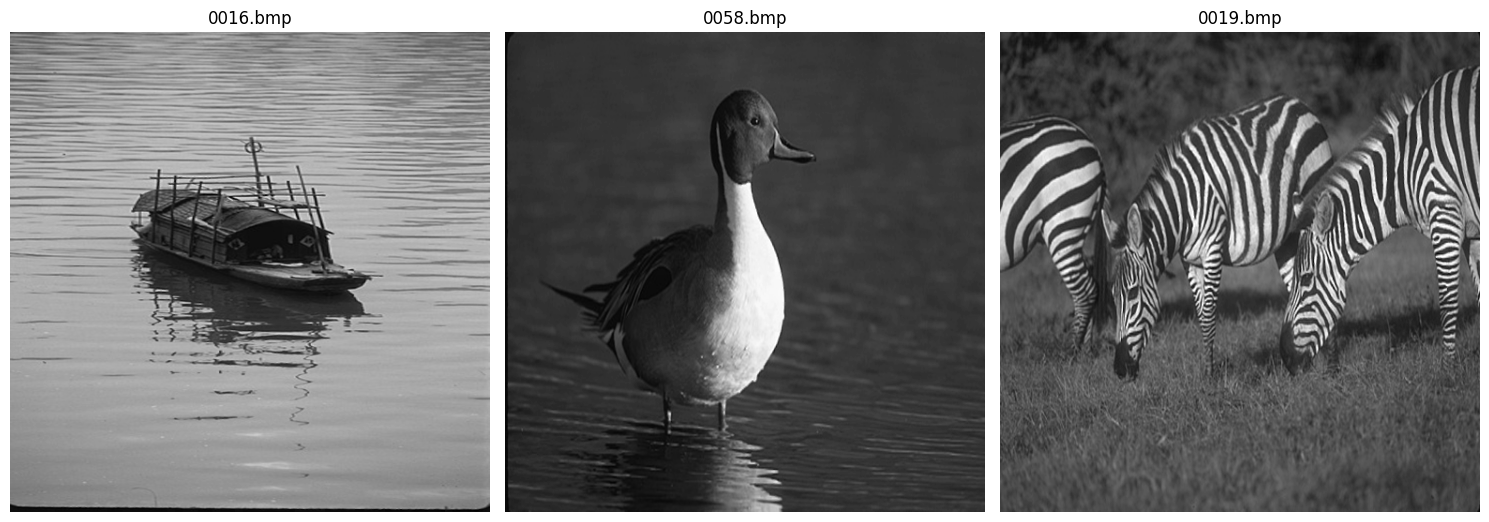

In [3]:
N = 3
images = []
watermarked = []
alpha = 0.88
max_layer = 2
mask = 2
avg = 0
min = 9999999999

watermarked.append(cv2.imread("out/watermarked_0.bmp", 0))
watermarked.append(cv2.imread("out/watermarked_4.bmp", 0))
watermarked.append(cv2.imread("out/watermarked_9.bmp", 0))
watermarked = np.array(watermarked)

img_files = ["0016.bmp", "0058.bmp", "0019.bmp"]

images.append(cv2.imread("sample_imgs/0016.bmp", 0))
images.append(cv2.imread("sample_imgs/0058.bmp", 0))
images.append(cv2.imread("sample_imgs/0019.bmp", 0))
images = np.array(images)

utility.visualize_images_with_desc(watermarked, img_files)

# Randomly select N images
# img_folder = 'sample_imgs'
# img_files =  [f for f in os.listdir(img_folder) if f.endswith(('.bmp'))]
# img_files = random.sample(img_files, N)
# for file in img_files:
#     img_path = os.path.join(img_folder, file)
#     images.append(cv2.imread(img_path, 0))
# images = np.array(images)

# mark = np.load('ammhackati.npy')
   
# progress_bar = tqdm(images, desc = "Embedding the watermark in " + str(N) + " images")
# for index, img in enumerate(progress_bar):
#     watermarked.append(embedding.embedding(img, mark, alpha, max_layer, mask))
#     wpsnr = utility.wpsnr(img, watermarked[index])
#     avg += wpsnr
#     if wpsnr < min:
#         min = wpsnr
        
# avg = avg / N
# print("\nAverage wpsnr: " + str(avg) + ' --> ' + str(imperceptibility(avg)) + ' imperceptibility points')
# print("Min wpsnr: " + str(min) + ' --> ' + str(imperceptibility(min)) + ' imperceptibility points')

### Global attacks

1. Blur using gaussian filters

In [9]:
progress_bar = tqdm(watermarked, desc = "Blurring " + str(N) + " images")
history = []
successful_attacks = []
total = 0
succ = 0
avg = 0
max = 0

for index, wm in enumerate(progress_bar):
    for sigma in np.arange(0, 5, 0.1, dtype = np.float16):
        attacked, attack_name, usd = grt.blur_gauss(wm, sigma)
        detected = detection.detection(images[index], wm, attacked, alpha, max_layer, mask)
        wpsnr_attacked = utility.wpsnr(wm, attacked)
        log = {"image" : img_files[index],
                "attack" : attack_name,
                "param" : usd,
                "wpsnr" : wpsnr_attacked,
                "detection" : detected}
        history.append(log)
        if detected == 0 and wpsnr_attacked >= 35:
            total += wpsnr_attacked
            succ +=1
            successful_attacks.append(log)
            if wpsnr_attacked > max:
                max = wpsnr_attacked
            break

if succ > 0:
    avg = total/succ
    print("\nAverage wpsnr of successful attacks: " + str(avg) + ' --> ' + str(robustness(avg)) + ' robustness points')
    print("Max wpsnr of successful attacks: " + str(max) + ' --> ' + str(robustness(max)) + ' robustness points\n') 
else:
    print("\nThis attack is not very effective... --> 6 robustness points\n")
 
for s in successful_attacks:
    print(s) 

Blurring 3 images: 100%|██████████| 3/3 [00:36<00:00, 12.17s/it]


Average wpsnr of successful attacks: 48.98003795469782 --> 2 robustness points
Max wpsnr of successful attacks: 52.384118401063546 --> 1 robustness points

{'image': '0016.bmp', 'attack': 'blur_gauss', 'param': {'sigma': 0.5}, 'wpsnr': 49.957115480794975, 'detection': 0}
{'image': '0058.bmp', 'attack': 'blur_gauss', 'param': {'sigma': 0.2}, 'wpsnr': 52.384118401063546, 'detection': 0}
{'image': '0019.bmp', 'attack': 'blur_gauss', 'param': {'sigma': 0.5996}, 'wpsnr': 44.59887998223494, 'detection': 0}


2. Blur using median filters

In [10]:
progress_bar = tqdm(watermarked, desc = "Blurring " + str(N) + " images")
history = []
successful_attacks = []
total = 0
succ = 0
avg = 0
max = 0

for index, wm in enumerate(progress_bar):
    for height in np.arange(1, 10, 2):
        for width in np.arange(1, 10, 2):
            attacked, attack_name, usd = grt.blur_median(wm, [height, width])
            detected = detection.detection(images[index], wm, attacked, alpha, max_layer, mask)
            wpsnr_attacked = utility.wpsnr(wm, attacked)
            log = {"image" : img_files[index],
                    "attack" : attack_name,
                    "param" : usd,
                    "wpsnr" : wpsnr_attacked,
                    "detection" : detected}
            history.append(log)
            if detected == 0 and wpsnr_attacked >= 35:
                total += wpsnr_attacked
                succ +=1
                successful_attacks.append(log)
                if wpsnr_attacked > max:
                    max = wpsnr_attacked
                break

if succ > 0:
    avg = total/succ
    print("\nAverage wpsnr of successful attacks: " + str(avg) + ' --> ' + str(robustness(avg)) + ' robustness points')
    print("Max wpsnr of successful attacks: " + str(max) + ' --> ' + str(robustness(max)) + ' robustness points\n') 
else:
    print("\nThis attack is not very effective... --> 6 robustness points\n")

for s in successful_attacks:
    print(s) 

Blurring 3 images: 100%|██████████| 3/3 [02:43<00:00, 54.66s/it]


Average wpsnr of successful attacks: 45.58956166345919 --> 3 robustness points
Max wpsnr of successful attacks: 59.80167831999025 --> 0 robustness points

{'image': '0016.bmp', 'attack': 'blur_median', 'param': {'size': [1, 3]}, 'wpsnr': 56.42248644708186, 'detection': 0}
{'image': '0016.bmp', 'attack': 'blur_median', 'param': {'size': [3, 1]}, 'wpsnr': 43.1211829263614, 'detection': 0}
{'image': '0058.bmp', 'attack': 'blur_median', 'param': {'size': [1, 3]}, 'wpsnr': 59.80167831999025, 'detection': 0}
{'image': '0058.bmp', 'attack': 'blur_median', 'param': {'size': [3, 1]}, 'wpsnr': 58.302403029305545, 'detection': 0}
{'image': '0058.bmp', 'attack': 'blur_median', 'param': {'size': [5, 1]}, 'wpsnr': 47.351183734021085, 'detection': 0}
{'image': '0058.bmp', 'attack': 'blur_median', 'param': {'size': [7, 1]}, 'wpsnr': 42.31556610929434, 'detection': 0}
{'image': '0058.bmp', 'attack': 'blur_median', 'param': {'size': [9, 1]}, 'wpsnr': 39.33251693740648, 'detection': 0}
{'image': '0019.b

3. Adding white gaussian noise (AWGN)

In [11]:
progress_bar = tqdm(watermarked, desc = "Applying AWGN to " + str(N) + " images")
history = []
successful_attacks = []
total = 0
succ = 0
avg = 0
max = 0

for index, wm in enumerate(progress_bar):
    for std in range(0, 110, 10):
        attacked, attack_name, usd = grt.awgn(wm, 0, std, 100)
        detected = detection.detection(images[index], wm, attacked, alpha, max_layer, mask)
        wpsnr_attacked = utility.wpsnr(wm, attacked)
        log = {"image" : img_files[index],
                "attack" : attack_name,
                "param" : usd,
                "wpsnr" : wpsnr_attacked,
                "detection" : detected}
        history.append(log)
        if detected == 0 and wpsnr_attacked >= 35:
            total += wpsnr_attacked
            succ +=1
            successful_attacks.append(log)
            if wpsnr_attacked > max:
                max = wpsnr_attacked
            break

if succ > 0:
    avg = total/succ
    print("\nAverage wpsnr of successful attacks: " + str(avg) + ' --> ' + str(robustness(avg)) + ' robustness points')
    print("Max wpsnr of successful attacks: " + str(max) + ' --> ' + str(robustness(max)) + ' robustness points\n') 
else:
    print("\nThis attack is not very effective... --> 6 robustness points\n")
 
for s in successful_attacks:
    print(s)

Applying AWGN to 3 images: 100%|██████████| 3/3 [00:48<00:00, 16.10s/it]


Average wpsnr of successful attacks: 43.373240809165054 --> 4 robustness points
Max wpsnr of successful attacks: 43.3832442342612 --> 4 robustness points

{'image': '0016.bmp', 'attack': 'awgn', 'param': {'mean': 0, 'std': 10, 'seed': 100}, 'wpsnr': 43.36323738406891, 'detection': 0}
{'image': '0058.bmp', 'attack': 'awgn', 'param': {'mean': 0, 'std': 10, 'seed': 100}, 'wpsnr': 43.3832442342612, 'detection': 0}


4. JPEG compression

In [12]:
progress_bar = tqdm(watermarked, desc = "Compressing " + str(N) + " images")
history = []
successful_attacks = []
total = 0
succ = 0
avg = 0
max = 0

for index, wm in enumerate(progress_bar):
    for qf in range(0, 100, 2):
        attacked, attack_name, usd = grt.jpeg_compression(wm, (100 - qf))
        detected = detection.detection(images[index], wm, attacked, alpha, max_layer, mask)
        wpsnr_attacked = utility.wpsnr(wm, attacked)
        log = {"image" : img_files[index],
                "attack" : attack_name,
                "param" : usd,
                "wpsnr" : wpsnr_attacked,
                "detection" : detected}
        history.append(log)
        if detected == 0 and wpsnr_attacked >= 35:
            total += wpsnr_attacked
            succ +=1
            successful_attacks.append(log)
            if wpsnr_attacked > max:
                max = wpsnr_attacked
            break

if succ > 0:
    avg = total/succ
    print("\nAverage wpsnr of successful attacks: " + str(avg) + ' --> ' + str(robustness(avg)) + ' robustness points')
    print("Max wpsnr of successful attacks: " + str(max) + ' --> ' + str(robustness(max)) + ' robustness points\n') 
else:
    print("\nThis attack is not very effective... --> 6 robustness points\n")

for s in successful_attacks:
    print(s)

Compressing 3 images: 100%|██████████| 3/3 [02:12<00:00, 44.13s/it]


Average wpsnr of successful attacks: 60.679870608589006 --> 0 robustness points
Max wpsnr of successful attacks: 73.96277372799427 --> 0 robustness points

{'image': '0016.bmp', 'attack': 'jpeg_compression', 'param': {'qf': 86}, 'wpsnr': 62.052660738989445, 'detection': 0}
{'image': '0058.bmp', 'attack': 'jpeg_compression', 'param': {'qf': 100}, 'wpsnr': 73.96277372799427, 'detection': 0}
{'image': '0019.bmp', 'attack': 'jpeg_compression', 'param': {'qf': 26}, 'wpsnr': 46.0241773587833, 'detection': 0}


5. Resizing

In [13]:
progress_bar = tqdm(watermarked, desc = "Resizing " + str(N) + " images")
history = []
successful_attacks = []
total = 0
succ = 0
avg = 0
max = 0

for index, wm in enumerate(progress_bar):
    for scale in np.arange(0, 1, 0.02, dtype = np.float16):
        attacked, attack_name, usd = grt.resize(wm, (1 - scale))
        detected = detection.detection(images[index], wm, attacked, alpha, max_layer, mask)
        wpsnr_attacked = utility.wpsnr(wm, attacked)
        log = {"image" : img_files[index],
                "attack" : attack_name,
                "param" : usd,
                "wpsnr" : wpsnr_attacked,
                "detection" : detected}
        history.append(log)
        if detected == 0 and wpsnr_attacked >= 35:
            total += wpsnr_attacked
            succ +=1
            successful_attacks.append(log)
            if wpsnr_attacked > max:
                max = wpsnr_attacked
            break

if succ > 0:
    avg = total/succ
    print("\nAverage wpsnr of successful attacks: " + str(avg) + ' --> ' + str(robustness(avg)) + ' robustness points')
    print("Max wpsnr of successful attacks: " + str(max) + ' --> ' + str(robustness(max)) + ' robustness points\n') 
else:
    print("\nThis attack is not very effective... --> 6 robustness points\n")
 
for s in successful_attacks:
    print(s) 

Resizing 3 images: 100%|██████████| 3/3 [00:16<00:00,  5.41s/it]


Average wpsnr of successful attacks: 48.46692071881463 --> 2 robustness points
Max wpsnr of successful attacks: 53.56367241816755 --> 0 robustness points

{'image': '0016.bmp', 'attack': 'resize', 'param': {'scale': 0.9799957275390625}, 'wpsnr': 47.20963834353232, 'detection': 0}
{'image': '0058.bmp', 'attack': 'resize', 'param': {'scale': 0.9799957275390625}, 'wpsnr': 53.56367241816755, 'detection': 0}
{'image': '0019.bmp', 'attack': 'resize', 'param': {'scale': 0.9799957275390625}, 'wpsnr': 44.627451394744014, 'detection': 0}


6. Sharpening

In [14]:
progress_bar = tqdm(watermarked, desc = "Sharpening " + str(N) + " images")
history = []
successful_attacks = []
total = 0
succ = 0
avg = 0
max = 0

for index, wm in enumerate(progress_bar):
    for sigma in np.arange(0, 5, 0.2, dtype = np.float16):
        for a in np.arange(0, 1, 0.1, dtype = np.float16):
            attacked, attack_name, usd = grt.sharp(wm, sigma, a)
            detected = detection.detection(images[index], wm, attacked, alpha, max_layer, mask)
            wpsnr_attacked = utility.wpsnr(wm, attacked)
            log = {"image" : img_files[index],
                    "attack" : attack_name,
                    "param" : usd,
                    "wpsnr" : wpsnr_attacked,
                    "detection" : detected}
            history.append(log)
            if detected == 0 and wpsnr_attacked >= 35:
                total += wpsnr_attacked
                succ +=1
                successful_attacks.append(log)
                if wpsnr_attacked > max:
                    max = wpsnr_attacked
                break

if succ > 0:
    avg = total/succ
    print("\nAverage wpsnr of successful attacks: " + str(avg) + ' --> ' + str(robustness(avg)) + ' robustness points')
    print("Max wpsnr of successful attacks: " + str(max) + ' --> ' + str(robustness(max)) + ' robustness points\n') 
else:
    print("\nThis attack is not very effective... --> 6 robustness points\n")
 
for s in successful_attacks:
    print(s) 

Sharpening 3 images:   0%|          | 0/3 [10:57<?, ?it/s]


KeyboardInterrupt: 

### Localized attacks

1. Blur edges using gaussian filters 

In [15]:
progress_bar = tqdm(watermarked, desc = "Blurring edges of " + str(N) + " images")
history = []
successful_attacks = []
total = 0
succ = 0
avg = 0
max = 0

for index, wm in enumerate(progress_bar):
    for edge_func in range(0, 2):
        for sigma in np.arange(0, 5, 0.1, dtype = np.float16):        
            attacked, attack_name, usd = grt.gauss_edge(wm, sigma, edge_func)
            detected = detection.detection(images[index], wm, attacked, alpha, max_layer, mask)
            wpsnr_attacked = utility.wpsnr(wm, attacked)
            log = {"image" : img_files[index],
                    "attack" : attack_name,
                    "param" : usd,
                    "wpsnr" : wpsnr_attacked,
                    "detection" : detected}
            history.append(log)
            if detected == 0 and wpsnr_attacked >= 35:
                total += wpsnr_attacked
                succ +=1
                successful_attacks.append(log)
                if wpsnr_attacked > max:
                    max = wpsnr_attacked
                break

if succ > 0:
    avg = total/succ
    print("\nAverage wpsnr of successful attacks: " + str(avg) + ' --> ' + str(robustness(avg)) + ' robustness points')
    print("Max wpsnr of successful attacks: " + str(max) + ' --> ' + str(robustness(max)) + ' robustness points\n') 
else:
    print("\nThis attack is not very effective... --> 6 robustness points\n")
 
for s in successful_attacks:
    print(s) 

Blurring edges of 3 images: 100%|██████████| 3/3 [01:04<00:00, 21.37s/it]


Average wpsnr of successful attacks: 56.018680810914816 --> 0 robustness points
Max wpsnr of successful attacks: 65.22960415131028 --> 0 robustness points

{'image': '0016.bmp', 'attack': 'gauss_edge', 'param': {'sigma': 0.4, 'edge_func': 0}, 'wpsnr': 58.28391240189119, 'detection': 0}
{'image': '0016.bmp', 'attack': 'gauss_edge', 'param': {'sigma': 0.5, 'edge_func': 1}, 'wpsnr': 55.99566007704753, 'detection': 0}
{'image': '0058.bmp', 'attack': 'gauss_edge', 'param': {'sigma': 0.5, 'edge_func': 0}, 'wpsnr': 61.384510368610854, 'detection': 0}
{'image': '0058.bmp', 'attack': 'gauss_edge', 'param': {'sigma': 0.5, 'edge_func': 1}, 'wpsnr': 65.22960415131028, 'detection': 0}
{'image': '0019.bmp', 'attack': 'gauss_edge', 'param': {'sigma': 0.5, 'edge_func': 0}, 'wpsnr': 49.82148726235557, 'detection': 0}
{'image': '0019.bmp', 'attack': 'gauss_edge', 'param': {'sigma': 0.9, 'edge_func': 1}, 'wpsnr': 45.396910604273515, 'detection': 0}


2. Blur edges using median filters

In [16]:
progress_bar = tqdm(watermarked, desc = "Blurring edges of " + str(N) + " images")
history = []
successful_attacks = []
total = 0
succ = 0
avg = 0
max = 0

for index, wm in enumerate(progress_bar):
    for edge_func in range(0, 2):
        for height in np.arange(1, 10, 2):
            for width in np.arange(1, 10, 2):       
                attacked, attack_name, usd = grt.median_edge(wm, [height, width], edge_func)
                detected = detection.detection(images[index], wm, attacked, alpha, max_layer, mask)
                wpsnr_attacked = utility.wpsnr(wm, attacked)
                log = {"image" : img_files[index],
                        "attack" : attack_name,
                        "param" : usd,
                        "wpsnr" : wpsnr_attacked,
                        "detection" : detected}
                history.append(log)
                if detected == 0 and wpsnr_attacked >= 35:
                    total += wpsnr_attacked
                    succ +=1
                    successful_attacks.append(log)
                    if wpsnr_attacked > max:
                        max = wpsnr_attacked
                    break

if succ > 0:
    avg = total/succ
    print("\nAverage wpsnr of successful attacks: " + str(avg) + ' --> ' + str(robustness(avg)) + ' robustness points')
    print("Max wpsnr of successful attacks: " + str(max) + ' --> ' + str(robustness(max)) + ' robustness points\n') 
else:
    print("\nThis attack is not very effective... --> 6 robustness points\n")
 
for s in successful_attacks:
    print(s) 

Blurring edges of 3 images: 100%|██████████| 3/3 [06:20<00:00, 126.73s/it]


Average wpsnr of successful attacks: 43.85557350249561 --> 4 robustness points
Max wpsnr of successful attacks: 61.199134633495675 --> 0 robustness points

{'image': '0016.bmp', 'attack': 'median_edge', 'param': {'size': [1, 5], 'edge_func': 0}, 'wpsnr': 47.41406757313114, 'detection': 0}
{'image': '0016.bmp', 'attack': 'median_edge', 'param': {'size': [3, 1], 'edge_func': 0}, 'wpsnr': 48.090384399378756, 'detection': 0}
{'image': '0016.bmp', 'attack': 'median_edge', 'param': {'size': [5, 1], 'edge_func': 0}, 'wpsnr': 35.80527532604477, 'detection': 0}
{'image': '0016.bmp', 'attack': 'median_edge', 'param': {'size': [1, 7], 'edge_func': 1}, 'wpsnr': 49.770430988237976, 'detection': 0}
{'image': '0016.bmp', 'attack': 'median_edge', 'param': {'size': [3, 1], 'edge_func': 1}, 'wpsnr': 47.82113651574189, 'detection': 0}
{'image': '0016.bmp', 'attack': 'median_edge', 'param': {'size': [5, 1], 'edge_func': 1}, 'wpsnr': 40.98454711874411, 'detection': 0}
{'image': '0016.bmp', 'attack': 'medi

3. Blur flat regions using gaussian filters

In [17]:
progress_bar = tqdm(watermarked, desc = "Blurring flat regions of " + str(N) + " images")
history = []
successful_attacks = []
total = 0
succ = 0
avg = 0
max = 0

for index, wm in enumerate(progress_bar):
    for edge_func in range(0, 2):
        for sigma in np.arange(0, 5, 0.1, dtype = np.float16):        
            attacked, attack_name, usd = grt.gauss_flat(wm, sigma, edge_func)
            detected = detection.detection(images[index], wm, attacked, alpha, max_layer, mask)
            wpsnr_attacked = utility.wpsnr(wm, attacked)
            log = {"image" : img_files[index],
                    "attack" : attack_name,
                    "param" : usd,
                    "wpsnr" : wpsnr_attacked,
                    "detection" : detected}
            history.append(log)
            if detected == 0 and wpsnr_attacked >= 35:
                total += wpsnr_attacked
                succ +=1
                successful_attacks.append(log)
                if wpsnr_attacked > max:
                    max = wpsnr_attacked
                break

if succ > 0:
    avg = total/succ
    print("\nAverage wpsnr of successful attacks: " + str(avg) + ' --> ' + str(robustness(avg)) + ' robustness points')
    print("Max wpsnr of successful attacks: " + str(max) + ' --> ' + str(robustness(max)) + ' robustness points\n') 
else:
    print("\nThis attack is not very effective... --> 6 robustness points\n")
 
for s in successful_attacks:
    print(s) 

Blurring flat regions of 3 images: 100%|██████████| 3/3 [02:08<00:00, 42.89s/it]


Average wpsnr of successful attacks: 50.03533170585859 --> 1 robustness points
Max wpsnr of successful attacks: 52.66506926205459 --> 1 robustness points

{'image': '0016.bmp', 'attack': 'gauss_flat', 'param': {'sigma': 0.8, 'edge_func': 0}, 'wpsnr': 46.84379464366667, 'detection': 0}
{'image': '0016.bmp', 'attack': 'gauss_flat', 'param': {'sigma': 0.5, 'edge_func': 1}, 'wpsnr': 51.549107425642184, 'detection': 0}
{'image': '0058.bmp', 'attack': 'gauss_flat', 'param': {'sigma': 0.2, 'edge_func': 0}, 'wpsnr': 52.58479642590868, 'detection': 0}
{'image': '0058.bmp', 'attack': 'gauss_flat', 'param': {'sigma': 0.2, 'edge_func': 1}, 'wpsnr': 52.66506926205459, 'detection': 0}
{'image': '0019.bmp', 'attack': 'gauss_flat', 'param': {'sigma': 0.5996, 'edge_func': 1}, 'wpsnr': 46.53389077202085, 'detection': 0}


4. Blur flat regions using median filters

In [18]:
progress_bar = tqdm(watermarked, desc = "Blurring flat regions of " + str(N) + " images")
history = []
successful_attacks = []
total = 0
succ = 0
avg = 0
max = 0

for index, wm in enumerate(progress_bar):
    for edge_func in range(0, 2):
        for height in np.arange(1, 10, 2):
            for width in np.arange(1, 10, 2):       
                attacked, attack_name, usd = grt.median_flat(wm, [height, width], edge_func)
                detected = detection.detection(images[index], wm, attacked, alpha, max_layer, mask)
                wpsnr_attacked = utility.wpsnr(wm, attacked)
                log = {"image" : img_files[index],
                        "attack" : attack_name,
                        "param" : usd,
                        "wpsnr" : wpsnr_attacked,
                        "detection" : detected}
                history.append(log)
                if detected == 0 and wpsnr_attacked >= 35:
                    total += wpsnr_attacked
                    succ +=1
                    successful_attacks.append(log)
                    if wpsnr_attacked > max:
                        max = wpsnr_attacked
                    break

if succ > 0:
    avg = total/succ
    print("\nAverage wpsnr of successful attacks: " + str(avg) + ' --> ' + str(robustness(avg)) + ' robustness points')
    print("Max wpsnr of successful attacks: " + str(max) + ' --> ' + str(robustness(max)) + ' robustness points\n') 
else:
    print("\nThis attack is not very effective... --> 6 robustness points\n")
 
for s in successful_attacks:
    print(s) 

Blurring flat regions of 3 images: 100%|██████████| 3/3 [03:33<00:00, 71.26s/it]


Average wpsnr of successful attacks: 46.622895540695446 --> 3 robustness points
Max wpsnr of successful attacks: 62.62455703451857 --> 0 robustness points

{'image': '0016.bmp', 'attack': 'median_flat', 'param': {'size': [3, 1], 'edge_func': 0}, 'wpsnr': 44.25460635784737, 'detection': 0}
{'image': '0016.bmp', 'attack': 'median_flat', 'param': {'size': [5, 1], 'edge_func': 0}, 'wpsnr': 40.80542833758608, 'detection': 0}
{'image': '0016.bmp', 'attack': 'median_flat', 'param': {'size': [7, 1], 'edge_func': 0}, 'wpsnr': 37.676807425764665, 'detection': 0}
{'image': '0016.bmp', 'attack': 'median_flat', 'param': {'size': [9, 1], 'edge_func': 0}, 'wpsnr': 36.79286127062647, 'detection': 0}
{'image': '0016.bmp', 'attack': 'median_flat', 'param': {'size': [1, 5], 'edge_func': 1}, 'wpsnr': 48.13925807708371, 'detection': 0}
{'image': '0016.bmp', 'attack': 'median_flat', 'param': {'size': [3, 1], 'edge_func': 1}, 'wpsnr': 45.973801393586584, 'detection': 0}
{'image': '0016.bmp', 'attack': 'medi

5. Adding white gaussian noise (AWGN) to edges

In [19]:
progress_bar = tqdm(watermarked, desc = "Applying AWGN to edges of " + str(N) + " images")
history = []
successful_attacks = []
total = 0
succ = 0
avg = 0
max = 0

for index, wm in enumerate(progress_bar):
    for edge_func in range(0, 2):
        for std in range(0, 110, 10):      
            attacked, attack_name, usd = grt.awgn_edge(wm, 0, std, 100, edge_func)
            detected = detection.detection(images[index], wm, attacked, alpha, max_layer, mask)
            wpsnr_attacked = utility.wpsnr(wm, attacked)
            log = {"image" : img_files[index],
                    "attack" : attack_name,
                    "param" : usd,
                    "wpsnr" : wpsnr_attacked,
                    "detection" : detected}
            history.append(log)
            if detected == 0 and wpsnr_attacked >= 35:
                total += wpsnr_attacked
                succ +=1
                successful_attacks.append(log)
                if wpsnr_attacked > max:
                    max = wpsnr_attacked
                break

if succ > 0:
    avg = total/succ
    print("\nAverage wpsnr of successful attacks: " + str(avg) + ' --> ' + str(robustness(avg)) + ' robustness points')
    print("Max wpsnr of successful attacks: " + str(max) + ' --> ' + str(robustness(max)) + ' robustness points\n') 
else:
    print("\nThis attack is not very effective... --> 6 robustness points\n")
 
for s in successful_attacks:
    print(s) 

Applying AWGN to edges of 3 images: 100%|██████████| 3/3 [00:30<00:00, 10.31s/it]


Average wpsnr of successful attacks: 47.303261131530384 --> 2 robustness points
Max wpsnr of successful attacks: 56.818952310066834 --> 0 robustness points

{'image': '0016.bmp', 'attack': 'awgn_edge', 'param': {'mean': 0, 'std': 10, 'seed': 100, 'edge_func': 0}, 'wpsnr': 48.97696024281938, 'detection': 0}
{'image': '0016.bmp', 'attack': 'awgn_edge', 'param': {'mean': 0, 'std': 10, 'seed': 100, 'edge_func': 1}, 'wpsnr': 48.3214264346087, 'detection': 0}
{'image': '0058.bmp', 'attack': 'awgn_edge', 'param': {'mean': 0, 'std': 10, 'seed': 100, 'edge_func': 0}, 'wpsnr': 56.818952310066834, 'detection': 0}
{'image': '0058.bmp', 'attack': 'awgn_edge', 'param': {'mean': 0, 'std': 10, 'seed': 100, 'edge_func': 1}, 'wpsnr': 53.30889117872732, 'detection': 0}
{'image': '0019.bmp', 'attack': 'awgn_edge', 'param': {'mean': 0, 'std': 30, 'seed': 100, 'edge_func': 0}, 'wpsnr': 40.20792285758429, 'detection': 0}
{'image': '0019.bmp', 'attack': 'awgn_edge', 'param': {'mean': 0, 'std': 40, 'seed': 10

### Testing new attacks

In [5]:
importlib.reload(grt)

i = 2

attack_name = "sharp_median"
usd = {'size':3, 'sigma':0.2, 'alpha':1}
attacked = grt.attack("out/watermarked_0.bmp", attack_name, usd)
detected = detection.detection(images[i], watermarked[i], attacked, alpha, max_layer, mask)
wpsnr_attacked = utility.wpsnr(watermarked[i], attacked)
log = {"image" : img_files[i],
                    "attack" : attack_name,
                    "param" : usd,
                    "wpsnr" : wpsnr_attacked,
                    "detection" : detected}

print(log)

{'image': '0019.bmp', 'attack': 'sharp_median', 'param': {'size': 3, 'sigma': 0.2, 'alpha': 1}, 'wpsnr': 15.545491996906255, 'detection': 1}


| Attack            | 0016.bmp  | 0058.bmp  | 0019.bmp  |
| ----------------: | :-------: | :-------: | :-------: |
| blur_gauss        | 49.957    | 52.384    | 44.598    |
| blur_median       | 56.422    | 59.801    | 43.666    |
| awgn              | 43.363    | 43.383    | -         |
| jpeg_compression  | 62.301    | 73.962    | 46.024    |
| resize            | 47.209    | 53.563    | 44.627    |
| gauss_edge        | 58.283    | 65.229    | 49.821    |
| median_edge       | 49.770    | 61.199    | 40.847    |
| gauss_flat        | 51.549    | 52.665    | 46.533    |
| median_flat       | 48.139    | 62.624    | 41.726    |
| awgn_edge         | 48.976    | 56.818    | 40.207    |
| gauss_jpeg        |